# **PREPROCESSING**

In [2]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/df_DataCovid.csv", sep=',')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8,9,10,11,12,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = data
df[["Date" , "Time"]] = data.Date_Time.str.split(expand=True)
df[["DateOfInfection", "TimeOfInfection"]] = data.date_of_infection.str.split(expand=True)
df[["DateOfSymptoms", "TimeOfSymptoms"]] = data.date_of_symptoms.str.split(expand=True)
df[["DateOfRecovery", "TimeOfRecovery"]] = data.date_of_recovery.str.split(expand=True)
df[["DateOfDeath", "TimeOfDeath"]] = data.date_of_death.str.split(expand=True)
df[["DateOfHCIn", "TimeOfHCIn"]] = data.date_hospital_check_in.str.split(expand=True)
df[["DateOfHCOut", "TimeOfHCOut"]] = data.date_hospital_check_out.str.split(expand=True)
df[["DateOfTest", "TimeOfTest"]] = data.date_of_test.str.split(expand=True)

In [4]:
df.drop(columns=["Date_Time", "date_of_infection", "date_of_symptoms", 
                 "date_of_recovery", "date_of_death", "date_hospital_check_in", "date_hospital_check_out",
                "date_of_test" ], inplace=True, axis=1)
df

,Unnamed: 0,id,age,gender,infection_status,days_since_infection,residence_id,school_id,workplace_id,currentLocationID,currentLocationType,lat,lon,zone_id,is_notified_to_isolate,is_symptomatic,incubation_period,days_since_isolation,isolation_times,days_since_symptomatic,in_hospital,wears_mask,type_of_job,morbidity,exposure_time,infected_from_user_id,transmitted_count,asymptomatic_transmission,locationID_of_infection,income,household_size,bmi,test_result,Scenario,Date,Time,DateOfInfection,TimeOfInfection,DateOfSymptoms,TimeOfSymptoms,DateOfRecovery,TimeOfRecovery,DateOfDeath,TimeOfDeath,DateOfHCIn,TimeOfHCIn,DateOfHCOut,TimeOfHCOut,DateOfTest,TimeOfTest
0,0,32645,29,1,susceptible,0.0,282,3562,282,282,residential,-6.221990,106.971849,0,0,0,3.783601,0,0,0,0,0,Remote worker,None,1.837003,-1,0,-1,-1,5774.248719,6,25,-1,0000001_20200922055707,2020-01-01,00:00:00,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
1,1,20022,30,1,susceptible,0.0,2247,3605,4761,2247,residential,-6.244313,106.783033,8,0,0,9.117633,0,0,0,0,0,Health worker,None,1.808421,-1,0,-1,-1,14384.879182,1,24,-1,0000001_20200922055707,2020-01-01,00:00:00,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
2,2,18409,32,0,susceptible,0.0,2122,3590,4744,2122,residential,-6.173000,106.801472,2,0,0,2.042305,0,0,0,0,0,Other job,None,1.795266,-1,0,-1,-1,9502.567895,4,24,-1,0000001_20200922055707,2020-01-01,00:00:00,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
3,3,34113,29,1,susceptible,0.0,422,3576,3932,422,residential,-6.101532,106.914825,4,0,0,11.241115,0,0,0,0,0,Other job,None,1.805949,-1,0,-1,-1,7029.974753,5,20,-1,0000001_20200922055707,2020-01-01,00:00:00,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
4,4,40168,58,1,susceptible,0.0,1647,3586,4326,1647,residential,-6.171371,106.939750,4,0,0,9.082528,0,0,0,0,0,Other job,None,0.403426,-1,0,-1,-1,12378.711455,2,31,-1,0000001_20200922055707,2020-01-01,00:00:00,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6799995,6799995,32323,32,0,recovered,0.0,3125,3581,4104,3125,residential,-6.321332,106.866273,7,0,0,20.482251,0,0,0,0,0,Other job,None,1.564081,4107,1,1,3581,5740.383492,6,28,-1,0000001_20200922055707,2020-05-15,19:00:00,2020-02-04,16:00:00,NaN,NaN,2020-02-11,00:00:00,NaN,None,NaN,NaN,NaN,NaN,NaN,None
6799996,6799996,38298,28,0,recovered,0.0,1776,3607,4441,1776,residential,-6.151697,106.763522,3,0,0,8.586859,0,0,0,0,0,Other job,None,0.950785,1117,1,1,4785,7136.902789,5,23,-1,0000001_20200922055707,2020-05-15,19:00:00,2020-03-16,22:00:00,2020-03-25,12:00:00,2020-03-25,18:00:00,NaN,None,2020-03-25,17:00:00,2020-03-25,18:00:00,NaN,None
6799997,6799997,32424,42,0,recovered,0.0,987,3598,4765,987,residential,-6.185989,106.984177,0,0,0,3.385301,0,0,0,0,0,Health worker,Hypertension,2.663911,9376,1,1,987,2739.946032,8,25,-1,0000001_20200922055707,2020-05-15,22:00:00,2020-02-19,03:00:00,NaN,NaN,2020-02-21,22:00:00,NaN,None,NaN,NaN,NaN,NaN,NaN,None
6799998,6799998,32323,32,0,recovered,0.0,3125,3581,4104,3125,residential,-6.321332,106.866273,7,0,0,20.482251,0,0,0,0,0,Other job,None,1.784631,4107,1,1,3581,5740.383492,6,28,-1,0000001_20200922055707,2020-05-15,22:00:00,2020-02-04,16:00:00,NaN,NaN,2020-02-11,00:00:00,NaN,None,NaN,NaN,NaN,NaN,NaN,None


# **TASK 01 : Data Analytics Questions**

In [6]:
#How many active cases (infected individuals) were there on 2020-03-01 (01 March 2020)?
print("Active Cases of Mar 01, 2020 : ",len((df.loc[(df["Date"] == "2020-03-01" ) & (df["infection_status"] == "infected")]).drop_duplicates(subset=["id"])))

Active Cases of Mar 01, 2020 :  1031


In [7]:
#How many people died on 2020-03-01 (01 March 2020)?
print(len((df[(df["DateOfDeath"] == "2020-03-01")& (df["infection_status"]=="deceased") ].loc[:,"id"]).drop_duplicates()), " people died on Mar 01,2020")

2  people died on Mar 01,2020


In [8]:
#What is the total number of infections, recoveries and deaths?
print("Total No of Infections", len((df[(df["infection_status"] == "infected" )].loc[:,"id"]).drop_duplicates()),
      "Recoveries", len((df[(df["infection_status"] == "recovered")].loc[:,"id"]).drop_duplicates()) ,
      "and Deaths", len((df[(df["infection_status"] == "deceased" )].loc[:,"id"]).drop_duplicates()))

Total No of Infections 3854 Recoveries 3658 and Deaths 215


In [9]:
#How many unique individuals in the dataset?
print(" Total No of Unique Individuals : ",len(df["id"].unique()))

 Total No of Unique Individuals :  10000


In [10]:
# How many unique locations and their names in the dataset?
print("Total IDs : ",df["currentLocationID"].nunique())
print("Names of Locations : ",  df["currentLocationType"].unique())

Total IDs :  4575
Names of Locations :  ['residential' 'shopping_mall' 'market' 'school' 'employment' 'hospital']


In [11]:
# Which school is the closest to a residence ID = 3115?
import numpy as np
from scipy.spatial import distance

res = df[(df["residence_id"] == 3115 ) & (df["currentLocationType"] == "residential")].iloc[0]
lat = res["lat"]
lon = res["lon"]
school = df[(df["currentLocationType"] == "school")].loc[:,("lat","lon")]
mindist = 100

for i in range(len(school)):
    slat, slon = school["lat"].iloc[i] , school["lon"].iloc[i]
    dist = distance.euclidean((slat,slon),(lat, lon))

    if(mindist > dist ):
        scox, scoy = slat, slon
        mindist = dist

school = df[(df["currentLocationType"] == "school") & (df["lat"] == scox)&(df["lon"]==scoy)].iloc[0]
print("Nearest School ID : ", school["school_id"])

Nearest School ID :  3563


In [12]:
# What percentage of individuals aged b/w 30 and 60 visit schools at 08:00 am?
ageGroup = len((df[(df["age"] < 61) & (df["age"] > 29)]).drop_duplicates(subset=["id"]))
individuals = len((df[(df["age"] < 61) & (df["age"] > 29) &  (df["Time"] == "08:00:00") & 
                      (df["currentLocationType"] == "school")]).drop_duplicates(subset=["id"]))
print("Total Percentage : ", (individuals/ageGroup)*100)

Total Percentage :  97.05763804917372


In [13]:
# What is the most dominant daily path of individual (ID= 37415) ? Hint: There are 5 timestamps per day (00:00,08:00,16:00,19:00,22:00).
# An individual can be at his residence (currentLocationType) at given timestamp, then can move to school on the next time stamp and so on. 
import collections
person = df[df["id"]== 37415]
dates = person["Date"].unique()
sum = 0
path = []
for date in dates:
    path.append(np.array(person[(person["Date"]==date)].loc[:,"currentLocationType"]))

for specific_path in path:
    freq = np.count_nonzero(path==specific_path)
    if (freq > sum):
        sum = freq
        definite_path = specific_path

print("Dominant Daily Path : ", definite_path, " at a frquency of : ", sum)


Dominant Daily Path :  ['residential' 'employment' 'employment' 'residential' 'residential']  at a frquency of :  439


In [38]:
# What is the proximity(number of individuals sharing the same location) 
# of an individual ID (37415) at a given date and time?
indloc = np.array(df[(df["id"] == 37415) & (df["Date"] == "2020-03-01") & (df["Time"] == "16:00:00" )].loc[:,"currentLocationID"])
people = np.array(df[(df["id"] != 37415) & (df["Date"] == "2020-03-01") & (df["Time"] == "16:00:00")].loc[:,"currentLocationID"])
    
print("Proximity of sharing same location at March 1,2020 : ", np.count_nonzero((people == indloc))  )


Proximity of sharing same location at March 1,2020 :  3


In [15]:
# What is the age and gender of individual 37415?
# Did this individual get infected? If yes, how long did the infection last? And did the individual die?
person = df[df["id"]== 37415].iloc[0,:]
if (person["gender"]== 1):
    gender = "Male"
else:
    gender = "Female"
print("Age : ", person["age"] , " \nGender : ", gender)

infect_days = len((df.loc[(df["id"]== 37415) & (df["infection_status"] == "infected")]).drop_duplicates(subset=["Date"]))
print("Person 37415 was infected for ", infect_days, " days." )

dod = df[(df["id"]== 37415) & (df["infection_status"] == "deceased")]
if (len(dod["DateOfDeath"])>0):
    print ("Died On : ", dod["DateOfDeath"] )
else:
    print("Individual Survived")

Age :  30  
Gender :  Male
Person 37415 was infected for  29  days.
Individual Survived


In [16]:
# What is the infection and mortality rate of health care workers?

HealthWorkers =  len((df.loc[(df["type_of_job"] == "Health worker")]).drop_duplicates(subset=["id"]))
Infected  = len((df.loc[(df["type_of_job"] == "Health worker") & 
                        (df["infection_status"]=="infected")]).drop_duplicates(subset=["id"]))
Deceased = len((df.loc[(df["type_of_job"] == "Health worker") & 
                       (df["infection_status"]=="deceased")]).drop_duplicates(subset=["id"]))

print ("Total Workers : ", HealthWorkers)
print("Total Worker Infected : ", Infected )
print("Total Worker Deceased : ", Deceased )
print("Infection Rate in Health Care Workers : " , (Infected/HealthWorkers)*100 )
print("Mortality Rate In Health Care Workers : " , (Deceased/HealthWorkers)*100 )

Total Workers :  403
Total Worker Infected :  387
Total Worker Deceased :  25
Infection Rate in Health Care Workers :  96.02977667493796
Mortality Rate In Health Care Workers :  6.20347394540943


In [17]:
# Does the mortality rate change with age and gender?
people = np.array(df[(df["infection_status"] == "deceased")].loc[:,("age","gender")])
group = np.array(df[(df["infection_status"] == "deceased")].loc[:,("age","gender")].drop_duplicates(subset=["age","gender"]))
survived = np.array(df[(df["infection_status"] != "deceased")].loc[:,("age","gender")])

for person in group:
    deceased_ratio = np.count_nonzero((people == person)) 
    survived_ratio = np.count_nonzero((survived == person))
    total = deceased_ratio + survived_ratio
    print("Mortality Rate for age and gender ", person, " is ", (deceased_ratio/total)*100 )

Mortality Rate for age and gender  [58  1]  is  1.4143985099867453
Mortality Rate for age and gender  [31  0]  is  0.6860491530190598
Mortality Rate for age and gender  [44  1]  is  1.4265315205527356
Mortality Rate for age and gender  [39  1]  is  1.3291063216418422
Mortality Rate for age and gender  [59  1]  is  1.4493064125417068
Mortality Rate for age and gender  [38  0]  is  0.7443813782823071
Mortality Rate for age and gender  [32  0]  is  0.6939069117140483
Mortality Rate for age and gender  [84  0]  is  0.6998214621311784
Mortality Rate for age and gender  [42  1]  is  1.3259170007440393
Mortality Rate for age and gender  [76  0]  is  0.7123602236421726
Mortality Rate for age and gender  [57  1]  is  1.4884706796471503
Mortality Rate for age and gender  [44  0]  is  0.8565308221720273
Mortality Rate for age and gender  [33  0]  is  0.7289251069667179
Mortality Rate for age and gender  [62  1]  is  1.3278377757352942
Mortality Rate for age and gender  [33  1]  is  1.314200546133

# **TASK 02 : Visualization**

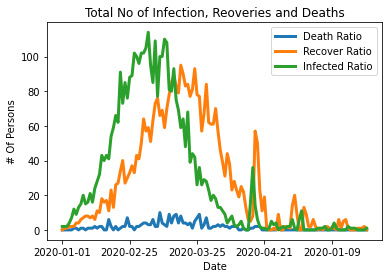

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot the total number of infections, recoveries and deaths w.r.t date
import matplotlib.pyplot as plt

freq = df[["id","Date", "infection_status"]].drop_duplicates(subset = ["id", "infection_status"], keep = "first")
x_data = np.array(freq["Date"].unique())

infected_data = []
recover_data= []
death_data = []

for value in x_data:
    infected_data.append(np.count_nonzero(np.logical_and.reduce(((freq["Date"] == value), (freq["infection_status"] == "infected") ))))
    recover_data.append(np.count_nonzero(np.logical_and((freq["Date"] == value), (freq["infection_status"] == "recovered"))))
    death_data.append(np.count_nonzero(np.logical_and((freq["Date"] == value), (freq["infection_status"] == "deceased"))))


plt.title("Total No of Infection, Reoveries and Deaths")

plt.plot(x_data,death_data, linewidth = 3,label = "Death Ratio")
plt.plot(x_data,recover_data, linewidth = 3,label = "Recover Ratio")
plt.plot(x_data,infected_data , linewidth = 3 , label = "Infected Ratio")

plt.xticks(x_data[::29])
plt.xlabel("Date")
plt.ylabel("# Of Persons")

plt.legend()
plt.figure()
plt.show()



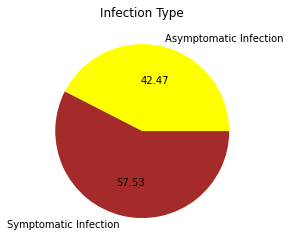

In [137]:
# Plot a pie chart for the ratio of asymptomatic and symptomatic infections.
assym = df[(df["is_symptomatic"] == 0) & (df["infection_status"] == "infected")].count()[0]
sym = df[(df["is_symptomatic"] == 1) & (df["infection_status"] == "infected")].count()[0]

plt.pie([assym,sym], autopct = '%.2f', labels = ["Asymptomatic Infection" , "Symptomatic Infection"], colors = ["yellow" , "brown"] )

plt.title("Infection Type")
plt.show()

In [21]:
# Plot the variation of proximity of individual (ID=37415) w.r.t date.
x_data = (df[df["id"] == 37415].loc[:, "Date"]).drop_duplicates()
Time = np.array(df["Time"].unique())

sum = 0
y_data = []

for date in x_data:
    indloc = np.array(df[(df["id"] == 37415) & (df["Date"] == "2020-03-01") & (df["Time"] == Time[0] )].loc[:,"currentLocationID"])
    people = np.array(df[(df["id"] != 37415) & (df["Date"] == "2020-03-01") & (df["Time"] == Time[0])].loc[:,"currentLocationID"])
    proximity = np.count_nonzero((people == indloc)
    if (sum < proximity):
        sum = proximity
    
    indloc = np.array(df[(df["id"] == 37415) & (df["Date"] == date) & (df["Time"] == Time[1] )].loc[:,"currentLocationID"])
    people = np.array(df[(df["id"] != 37415) & (df["Date"] == date) & (df["Time"] == Time[1])].loc[:,"currentLocationID"])
    proximity = np.count_nonzero((people == indloc)
    if (sum < proximity):
        sum = proximity
    
    indloc = np.array(df[(df["id"] == 37415) & (df["Date"] == date) & (df["Time"] == Time[2] )].loc[:,"currentLocationID"])
    people = np.array(df[(df["id"] != 37415) & (df["Date"] == date) & (df["Time"] == Time[2])].loc[:,"currentLocationID"])
    proximity = np.count_nonzero((people == indloc)
    if (sum < proximity):
        sum = proximity
    
    indloc = np.array(df[(df["id"] == 37415) & (df["Date"] == date) & (df["Time"] == Time[3] )].loc[:,"currentLocationID"])
    people = np.array(df[(df["id"] != 37415) & (df["Date"] == date) & (df["Time"] == Time[3])].loc[:,"currentLocationID"])
    proximity = np.count_nonzero((people == indloc)
    if (sum < proximity):
        sum = proximity
    
    indloc = np.array(df[(df["id"] == 37415) & (df["Date"] == date) & (df["Time"] == Time[4] )].loc[:,"currentLocationID"])
    people = np.array(df[(df["id"] != 37415) & (df["Date"] == date) & (df["Time"] == Time[4])].loc[:,"currentLocationID"])
    proximity = np.count_nonzero((people == indloc)
    if (sum < proximity):
        sum = proximity
    
    y_data.append(sum)
    sum = 0


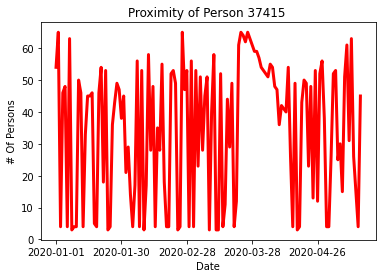

<Figure size 432x288 with 0 Axes>

In [23]:
plt.title("Proximity of Person 37415 ")

plt.plot(x_data, y_data, linewidth = 3, color = "red")
plt.xticks(x_data[::29])
plt.xlabel("Date")
plt.ylabel("# Of Persons")



plt.figure()
plt.show()

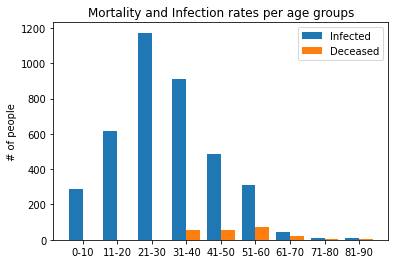

In [69]:
# Plot bar graphs to show the mortality rates and infection rates per age groups
Infected  = ((df[(df["infection_status"]=="infected")].loc[:, ["age","id"]]).drop_duplicates())
Deceased = ((df[(df["infection_status"]=="deceased")].loc[:, ["age","id"]]).drop_duplicates())

y_infect, y_dec =[], []
age_group = np.array(range(10,100,10))


for age in age_group:
    y_infect.append(((Infected[((Infected["age"] <= age) & (Infected["age"] > (age-10)))]).count()[0]))
    y_dec.append(((Deceased[((Deceased["age"] <= age) & (Deceased["age"] > (age-10)))]).count()[0]))

labels = ["0-10","11-20","21-30","31-40","41-50","51-60","61-70","71-80","81-90"]
x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar((x- width/2), y_infect, width, label='Infected')
rects2 = ax.bar((x + width/2), y_dec, width, label='Deceased')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of people')
ax.set_title('Mortality and Infection rates per age groups')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [ ]:
# Visualize the number of individuals at a location on a geographical map.
# import numpy as np

# residence = df["residence_id"].drop_duplicates()
# school = df["school_id"].drop_duplicates()
# work = df["workplace_id"].drop_duplicates()

# locIds = pd.DataFrame((df.loc[:,("currentLocationID","currentLocationType")]).drop_duplicates())
# loc = pd.DataFrame(df["currentLocationType"].drop_duplicates())

# proximity = pd.pivot_table(locIds, index=loc, aggfunc="size")
# locations = []
# loc = np.array(loc)

# for i in range(len(loc)):
#     locations.append(loc[i])
#     locations.append(proximity[i])


# import plotly.express as px
# fig = px.choropleth(locIds, geojson=counties, locations=locIds, color = proximity,
#                            color_continuous_scale="Viridis",
#                            range_color=(0, 12),
#                            scope="usa",
#                            labels={'unemp':'unemployment rate'}
#                           )
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()